In [5]:
train_labels = read.csv(file = '/Users/shreya/Desktop/STAT 503/train_labels.csv')
test_labels = read.csv(file = '/Users/shreya/Desktop/STAT 503/test_labels.csv')
train_x=read.csv(file = '/Users/shreya/Desktop/STAT 503/train_x.csv')
test_x=read.csv(file = '/Users/shreya/Desktop/STAT 503/test_x.csv')

In [6]:
train_labels=as.matrix(train_labels)
test_labels=as.matrix(test_labels)
train_x=as.matrix(train_x)
test_x=as.matrix(test_x)

In [41]:
head(train_x_smote)

Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74,15.6,76.5
32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86,33.2,79.3
32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80,33.8,75.7
32,0,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109,21.5,67.1
32,0,44.3,52.3,21.7,22.4,17.2,4.15,3.57,78,24.1,75.4
33,0,36.3,78.6,23.6,22.0,7.0,8.56,5.38,78,19.4,68.7


In [9]:
unique(test_labels)

V1
0
1
2
3


## SIMPLE MLP - Not SMOTE

In [1]:
library(reticulate)
library(tidyverse)

# Seeing your enviroments
conda_list()

Warning message:
“package ‘reticulate’ was built under R version 4.0.5”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



name,python
<chr>,<chr>
base,/Users/shreya/opt/anaconda3/bin/python
STAT507,/Users/shreya/opt/anaconda3/envs/STAT507/bin/python


In [2]:
install.packages('devtools')
devtools::install_github("rstudio/keras")
devtools::install_github("rstudio/tensorflow")
library(devtools)
library(tensorflow)
install_tensorflow(version = "2.8.0")
library(keras)
install_keras()

reticulate::use_condaenv("base", required = TRUE)


The downloaded binary packages are in
	/var/folders/0c/y78gmd852fg62dh0g5d1w9hr0000gn/T//RtmpAqJPo2/downloaded_packages


Skipping install of 'keras' from a github remote, the SHA1 (4e9a6daf) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'tensorflow' from a github remote, the SHA1 (b8c5290f) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: usethis




Installation complete.


Installation complete.



In [10]:
model_HCV <- keras_model_sequential()
model_HCV %>%
  layer_dense(units = 225, activation = 'relu') %>%
  layer_dense(units = 225, activation = 'relu') %>%
  layer_dropout(0.20) %>%
  layer_dense(units = 4, activation = 'softmax')

In [11]:
model_HCV %>% compile(
  optimizer = 'adam', 
  loss = 'sparse_categorical_crossentropy',
  metrics = c('accuracy')
)

In [12]:
model_HCV_fitted = model_HCV %>% fit(train_x, train_labels, epochs = 32)

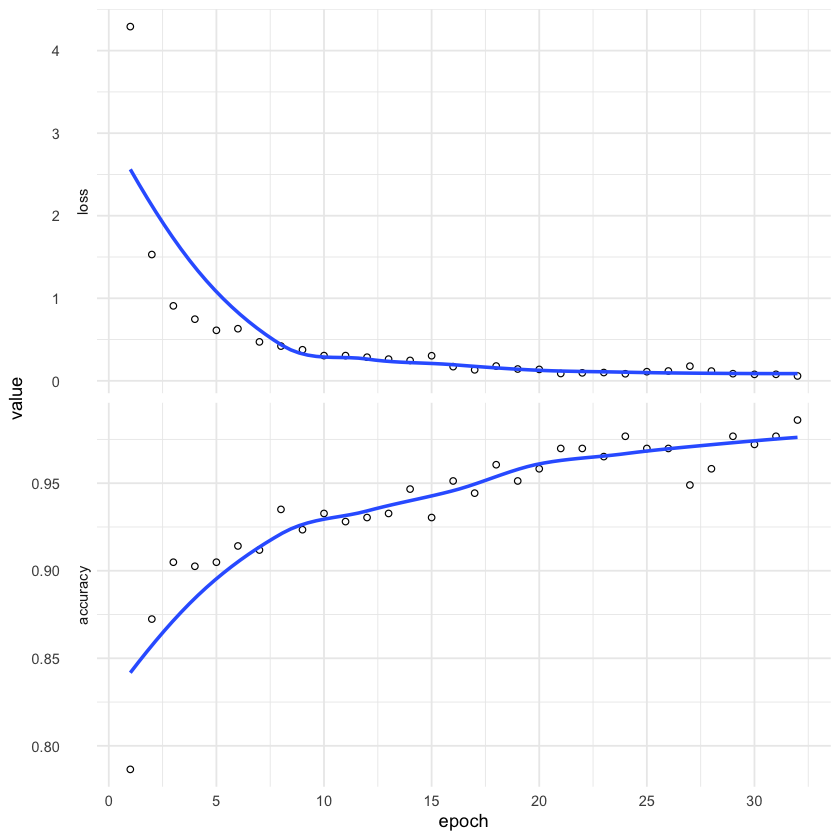

In [13]:
plot(model_HCV_fitted) + theme_minimal()

In [14]:
score = model_HCV %>% evaluate(test_x, test_labels)

cat('Test loss:', score[1], "\n")
cat('Test accuracy:', score[2], "\n")


Test loss: 0.4071616 
Test accuracy: 0.9184783 


In [15]:
library(ramify)
library(yardstick)
predictions <- model_HCV %>% predict(test_x) 
classes=argmax(predictions) %>% as.vector()



Attaching package: ‘ramify’


The following object is masked from ‘package:purrr’:

    flatten


The following object is masked from ‘package:tidyr’:

    fill


The following object is masked from ‘package:graphics’:

    clip


For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.


Attaching package: ‘yardstick’


The following object is masked from ‘package:keras’:

    get_weights


The following object is masked from ‘package:readr’:

    spec




In [17]:
estimates_keras_tbl <- tibble(
  truth      = as.factor(test_labels),
  estimate   = as.factor(classes),
  class_prob = predictions)
estimates_keras_tbl$class_prob_new = apply(estimates_keras_tbl$class_prob,1, FUN=max)
estimates_keras_tbl$estimate <- as.character(estimates_keras_tbl$estimate)

estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "1"] <- "0"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "2"] <- "1"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "3"] <- "2"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "4"] <- "3"

estimates_keras_tbl$estimate <- as.factor(estimates_keras_tbl$estimate)

In [18]:
library(purrr)
library(tidyr)

In [19]:
cm=estimates_keras_tbl %>% conf_mat(truth, estimate)
# Now reshape these into a matrix
tidy_cm=tidy(cm)
cm_mat <- matrix(tidy_cm$value, byrow = TRUE, ncol = 4)
rownames(cm_mat) <- c(0,1,2,3)
colnames(cm_mat) <- c(0,1,2,3)
cm_mat

,0,1,2,3
0,158,1,3,0
1,0,5,2,0
2,2,2,2,0
3,1,1,3,4


In [20]:
estimates_keras_tbl %>% metrics (truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9184783
kap,multiclass,0.6375575


In [21]:
n = sum(cm_mat) # number of instances
nc = nrow(cm_mat) # number of classes
diag = diag(cm_mat) # number of correctly classified instances per class 
rowsums = apply(cm_mat, 1, sum) # number of instances per class
colsums = apply(cm_mat, 2, sum) # number of predictions per class
p = rowsums / n # distribution of instances over the actual classes
q = colsums / n # distribution of instances over the predicted classes

In [22]:
precision = diag / colsums 
recall = diag / rowsums 
f1 = 2 * precision * recall / (precision + recall) 
data.frame(precision, recall, f1) 

,precision,recall,f1
,<dbl>,<dbl>,<dbl>
0,0.9813665,0.9753086,0.9783282
1,0.5555556,0.7142857,0.6250000
2,0.2000000,0.3333333,0.2500000
3,1.0000000,0.4444444,0.6153846


## SMOTE-Results

In [104]:
train_x_smote=read.csv(file = '/Users/shreya/Downloads/X_Train_SMOTE.csv')
train_labels_smote = read.csv(file = '/Users/shreya/Downloads/y_train_SMOTE.csv')
train_x_smote=as.matrix(train_x_smote)
train_labels_smote=as.matrix(train_labels_smote)

In [114]:
model_HCV_smote<- keras_model_sequential()
model_HCV_smote %>%
  layer_dense(units = 100, activation = 'tanh') %>%
  layer_dense(units = 200, activation = 'tanh') %>%
  layer_dropout(0.25) %>%
  layer_dense(units = 4, activation = 'softmax')

In [115]:
model_HCV_smote %>% compile(
  optimizer = 'adam', 
  loss = 'sparse_categorical_crossentropy',
  metrics = c('accuracy')
)

In [116]:
model_HCV_fitted_smote = model_HCV_smote %>% fit(train_x_smote, train_labels_smote, epochs = 32)

In [117]:
score = model_HCV_smote %>% evaluate(test_x, test_labels)

cat('Test loss:', score[1], "\n")
cat('Test accuracy:', score[2], "\n")

Test loss: 0.3398894 
Test accuracy: 0.9239131 


In [118]:
library(ramify)
library(yardstick)
predictions <- model_HCV_smote %>% predict(test_x) 
classes=argmax(predictions) %>% as.vector()

In [119]:
estimates_keras_tbl <- tibble(
  truth      = as.factor(test_labels),
  estimate   = as.factor(classes),
  class_prob = predictions)
estimates_keras_tbl$class_prob_new = apply(estimates_keras_tbl$class_prob,1, FUN=max)
estimates_keras_tbl$estimate <- as.character(estimates_keras_tbl$estimate)

estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "1"] <- "0"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "2"] <- "1"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "3"] <- "2"
estimates_keras_tbl$estimate[estimates_keras_tbl$estimate == "4"] <- "3"

estimates_keras_tbl$estimate <- as.factor(estimates_keras_tbl$estimate)

In [120]:
library(purrr)
library(tidyr)
cm=estimates_keras_tbl %>% conf_mat(truth, estimate)
# Now reshape these into a matrix
tidy_cm=tidy(cm)
cm_mat <- matrix(tidy_cm$value, byrow = TRUE, ncol = 4)
rownames(cm_mat) <- c(0,1,2,3)
colnames(cm_mat) <- c(0,1,2,3)
cm_mat

,0,1,2,3
0,157,1,2,2
1,0,3,3,1
2,1,1,3,1
3,0,0,2,7


In [126]:
n = sum(cm_mat) # number of instances
nc = nrow(cm_mat) # number of classes
diag = diag(cm_mat) # number of correctly classified instances per class 
rowsums = apply(cm_mat, 1, sum) # number of instances per class
colsums = apply(cm_mat, 2, sum) # number of predictions per class
p = rowsums / n # distribution of instances over the actual classes
q = colsums / n # distribution of instances over the predicted classes


In [143]:
tn_0=(3+3+1+1+3+1+0+2+7)
fp_0=(1+2+2)

tn_1=157+2+2+1+2+1+0+2+7
fp_1=0+3+1

tn_2=157+1+2+0+3+1+0+0+7
fp_2=3

tn_3=157+1+2+0+3+3+1+1+3
fp_3=2

In [145]:
precision = diag / colsums 
recall = diag / rowsums 
f1 = 2 * precision * recall / (precision + recall) 
data.frame(precision, recall, f1) 

,precision,recall,f1
,<dbl>,<dbl>,<dbl>
0,0.9936709,0.9691358,0.98125
1,0.6000000,0.4285714,0.50000
2,0.3000000,0.5000000,0.37500
3,0.6363636,0.7777778,0.70000


In [147]:
#specificity per class
c(tn_0/(tn_0+fp_0), tn_1/(tn_1+fp_1), tn_2/(tn_2+fp_2), tn_3/(tn_3+fp_3))

[1] 0.8076923 0.9775281 0.9827586 0.9884393